## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import train_test_split
from matplotlib.patches import ConnectionPatch
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train = df_train.drop(columns=['id'])
df_test = df_test.drop(columns=['id'])

## First Exploration

In [ ]:
df_train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [ ]:
print(df_train.shape, df_test.shape)

(58645, 12) (39098, 11)


In [ ]:
df_train.describe().round(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
count,58645.00,58645.00,58645.00,58645.00,58645.00,58645.00,58645.00,58645.00
mean,27.55,64046.17,4.70,9217.56,10.68,0.16,5.81,0.14
std,6.03,37931.11,3.96,5563.81,3.03,0.09,4.03,0.35
min,20.00,4200.00,0.00,500.00,5.42,0.00,2.00,0.00
25%,23.00,42000.00,2.00,5000.00,7.88,0.09,3.00,0.00
50%,26.00,58000.00,4.00,8000.00,10.75,0.14,4.00,0.00
75%,30.00,75600.00,7.00,12000.00,12.99,0.21,8.00,0.00
max,123.00,1900000.00,123.00,35000.00,23.22,0.83,30.00,1.00


In [ ]:
df_train.isnull().sum()

,0
person_age,0
person_income,0
person_home_ownership,0
person_emp_length,0
loan_intent,0
loan_grade,0
loan_amnt,0
loan_int_rate,0
loan_percent_income,0
cb_person_default_on_file,0


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  58645 non-null  int64  
 1   person_income               58645 non-null  int64  
 2   person_home_ownership       58645 non-null  object 
 3   person_emp_length           58645 non-null  float64
 4   loan_intent                 58645 non-null  object 
 5   loan_grade                  58645 non-null  object 
 6   loan_amnt                   58645 non-null  int64  
 7   loan_int_rate               58645 non-null  float64
 8   loan_percent_income         58645 non-null  float64
 9   cb_person_default_on_file   58645 non-null  object 
 10  cb_person_cred_hist_length  58645 non-null  int64  
 11  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 5.4+ MB


In [ ]:
df_train.nunique()

,0
person_age,53
person_income,2641
person_home_ownership,4
person_emp_length,36
loan_intent,6
loan_grade,7
loan_amnt,545
loan_int_rate,362
loan_percent_income,61
cb_person_default_on_file,2


## Data Analysis

### Functions to visualize

In [ ]:
sns.set_theme(style="whitegrid")

def plot_pie_charts_by_column(df, column):
    # Step 1: Calculate the number of approved and denied loans for each unique value in the column
    loan_counts = df.groupby([column, 'loan_status']).size().unstack(fill_value=0)

    # Step 2: Swap labels if needed (assuming 0 is 'Approved' and 1 is 'Denied')
    loan_counts.columns = ['Approved', 'Denied']

    # Step 3: Determine the number of unique values in the specified column
    unique_values = loan_counts.index
    num_unique_values = len(unique_values)

    # Step 4: Determine the number of rows and columns for subplots based on the number of unique values
    num_columns = min(3, num_unique_values)  # Maximum 3 columns
    num_rows = math.ceil(num_unique_values / num_columns)

    # Step 5: Create subplots to display multiple pie charts
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 3 * num_rows))  # Adjust height dynamically
    axes = axes.flatten() if num_unique_values > 1 else [axes]  # Flatten if there's more than 1 subplot

    # Step 6: Choose a Seaborn color palette that reflects approval and denial status
    sns_palette = sns.color_palette("Set2")  # Choose a Seaborn palette
    approved_color, denied_color = sns_palette[0], sns_palette[1]  # Select colors for approved and denied

    # Step 7: Create a pie chart for each unique value in the specified column
    for i, value in enumerate(unique_values):
        # Get the number of approved and denied loans for the current value
        sizes = loan_counts.loc[value]
        labels = ['Approved', 'Denied']

        # Create the pie chart on the corresponding axis
        wedges, texts, autotexts = axes[i].pie(
            sizes,
            labels=labels,
            autopct='%1.1f%%',  # Display only the percentage text
            startangle=140,
            colors=[approved_color, denied_color],  # Apply Seaborn colors
            wedgeprops={'edgecolor': 'w'},  # Add a white border between wedges for clarity
            textprops={'fontsize': 10, 'weight': 'bold'}  # Text properties for labels
        )

        # Set the simplified title for each subplot (just the intent)
        axes[i].set_title(value, fontsize=12, weight='bold')

        # Customize percentage text properties inside the pie chart
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_weight('bold')
            autotext.set_fontsize(10)

    # Remove empty subplots, if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Step 8: Add an overall title and layout adjustments
    fig.suptitle(f'Distribution of Loan Status by {column.capitalize()}', fontsize=15, weight='bold', y=0.98)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # Adjust the top to leave space for the main title

    # Show the plot
    plt.show()

In [ ]:
def plot_distribution_pie_chart(df, column):
    # Set the Seaborn theme for consistency
    sns.set_theme(style="whitegrid")

    # Step 1: Calculate the number of items for each category in the specified column
    column_counts = df[column].value_counts()

    # Step 2: Create a pie chart using matplotlib
    fig, ax = plt.subplots(figsize=(6, 6))

    # Use a Seaborn color palette
    colors = sns.color_palette("Set2", len(column_counts))

    # Create the pie chart
    wedges, texts, autotexts = ax.pie(
        column_counts,
        labels=column_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=colors,
        wedgeprops={'edgecolor': 'w'},  # Add a white border between wedges
        textprops={'fontsize': 10, 'weight': 'bold'}  # Text properties for labels
    )

    # Set properties for percentages inside the pie chart
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_weight('bold')
        autotext.set_fontsize(12)

    # Set the title of the pie chart
    ax.set_title(f'Distribution of {column.capitalize()}', fontsize=16, weight='bold')

    # Adjust the layout and show the plot
    plt.tight_layout()
    plt.show()

In [ ]:
def plot_histogram(df, column):
    sns.set_theme(style="whitegrid")

    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=column, bins=20, kde=True, color='skyblue')

    plt.title(f'Distribution of {column.capitalize()}', fontsize=12, weight='bold')
    plt.xlabel(column, fontsize=10, weight='bold')
    plt.ylabel('Count', fontsize=10, weight='bold')

    plt.tight_layout()
    plt.show()

### Pie Charts of Categorical Columns

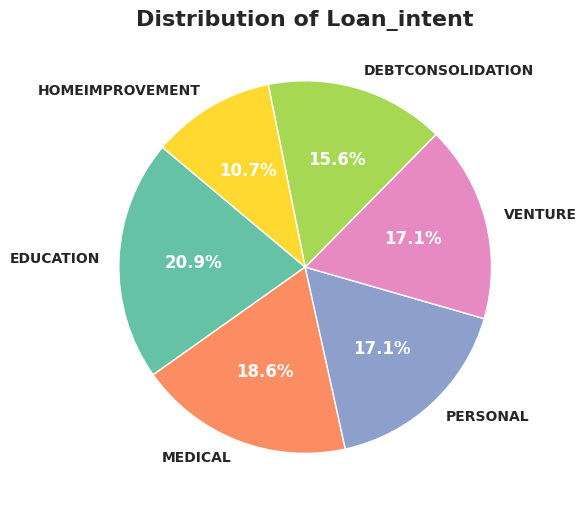

In [ ]:
plot_distribution_pie_chart(df_train, 'loan_intent')

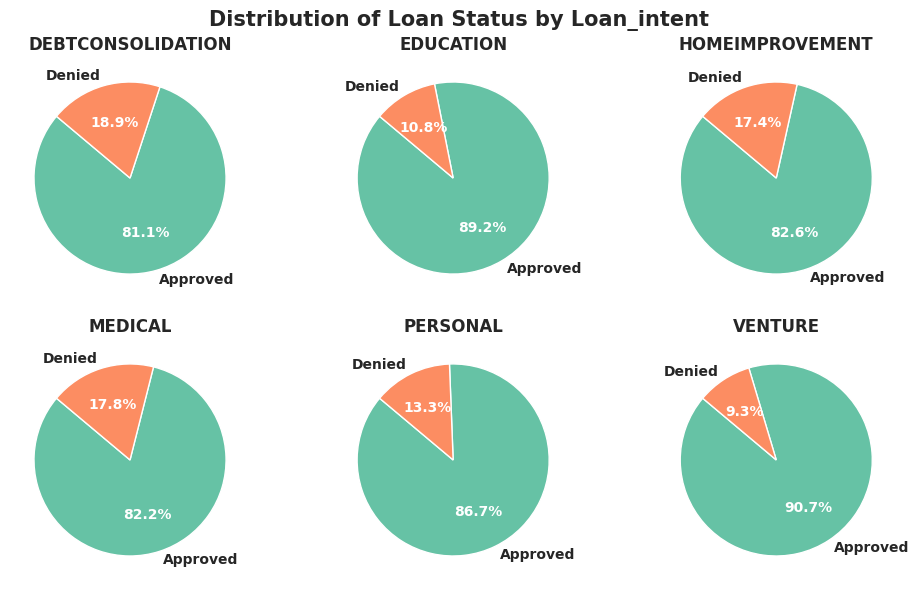

In [ ]:
plot_pie_charts_by_column(df_train, 'loan_intent')

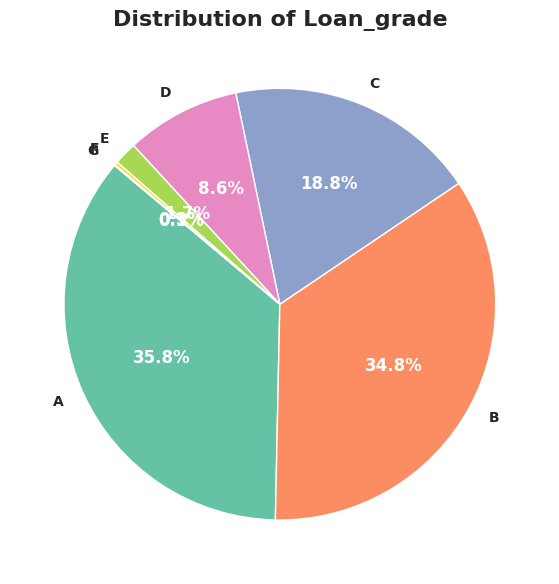

In [ ]:
plot_distribution_pie_chart(df_train, 'loan_grade')

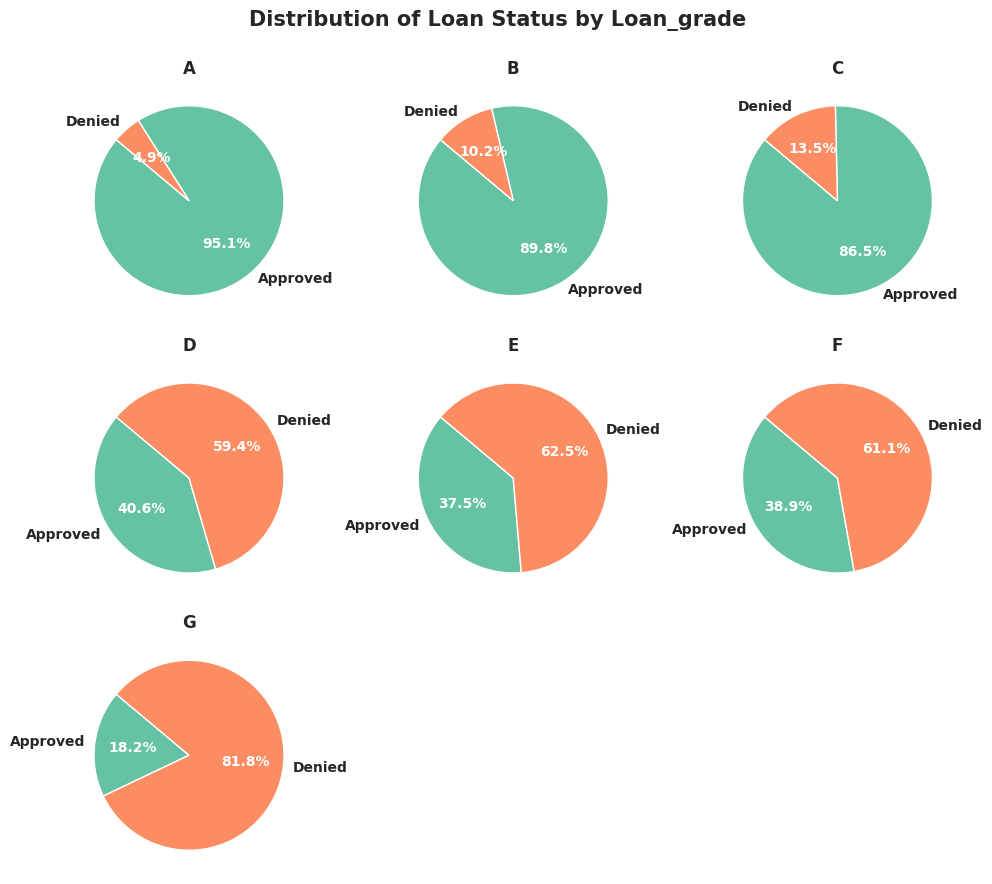

In [ ]:
plot_pie_charts_by_column(df_train, 'loan_grade')

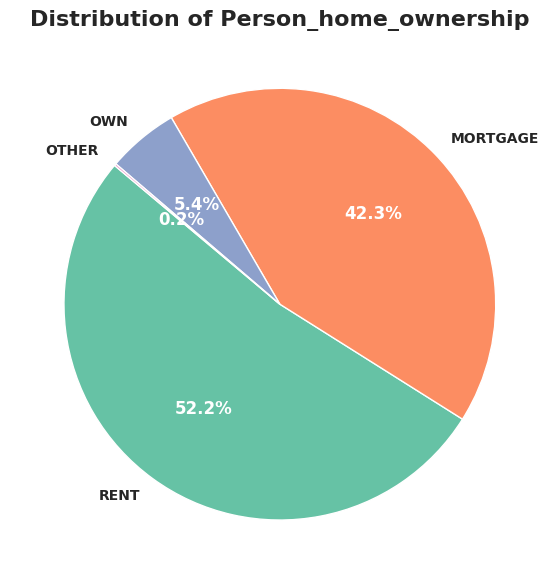

In [ ]:
plot_distribution_pie_chart(df_train, 'person_home_ownership')

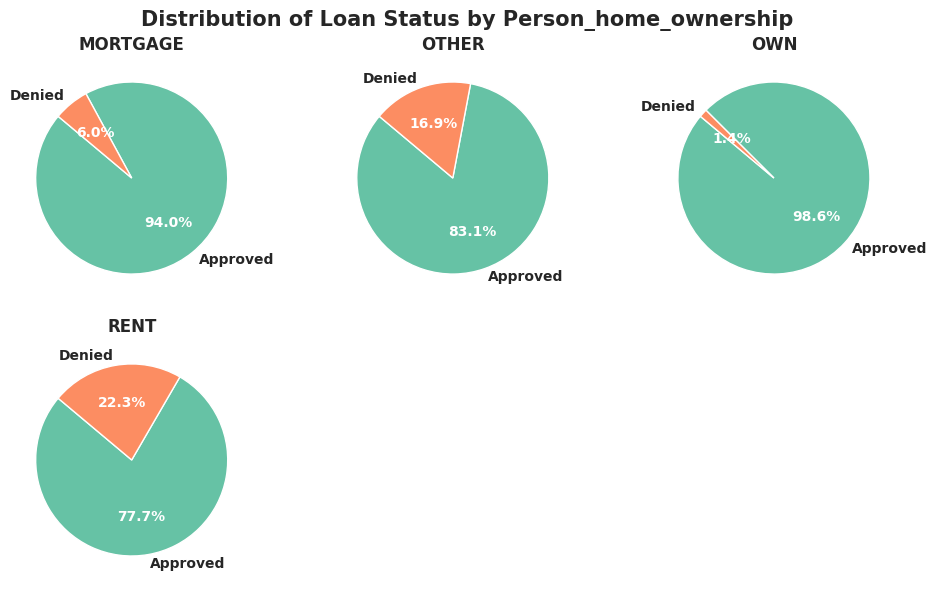

In [ ]:
plot_pie_charts_by_column(df_train, 'person_home_ownership')

### Histograms of numerical columns

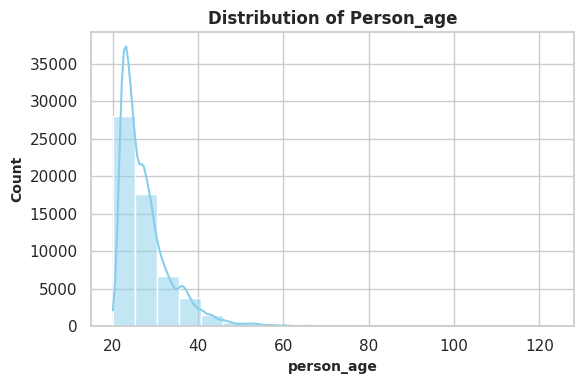

In [ ]:
plot_histogram(df_train, 'person_age')

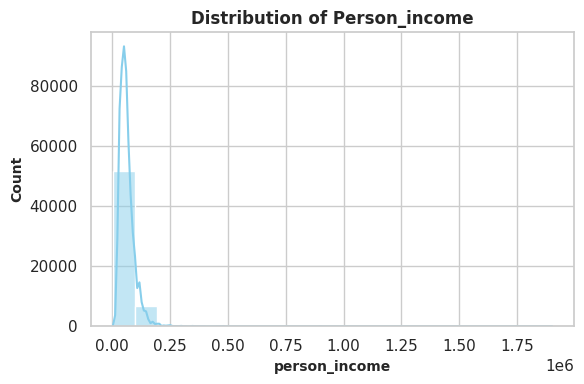

In [ ]:
plot_histogram(df_train, 'person_income')

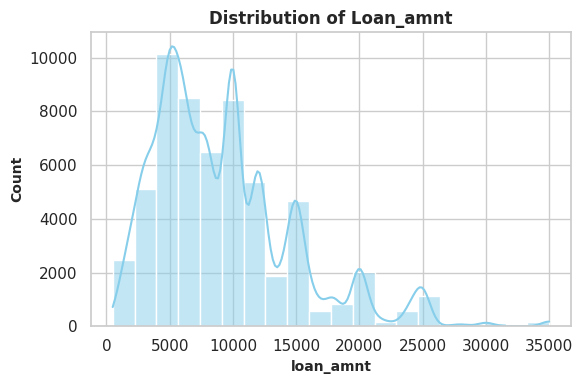

In [ ]:
plot_histogram(df_train, 'loan_amnt')

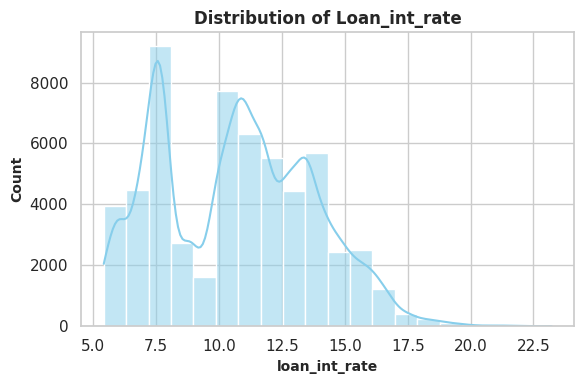

In [ ]:
plot_histogram(df_train, 'loan_int_rate')

### Combined relationships

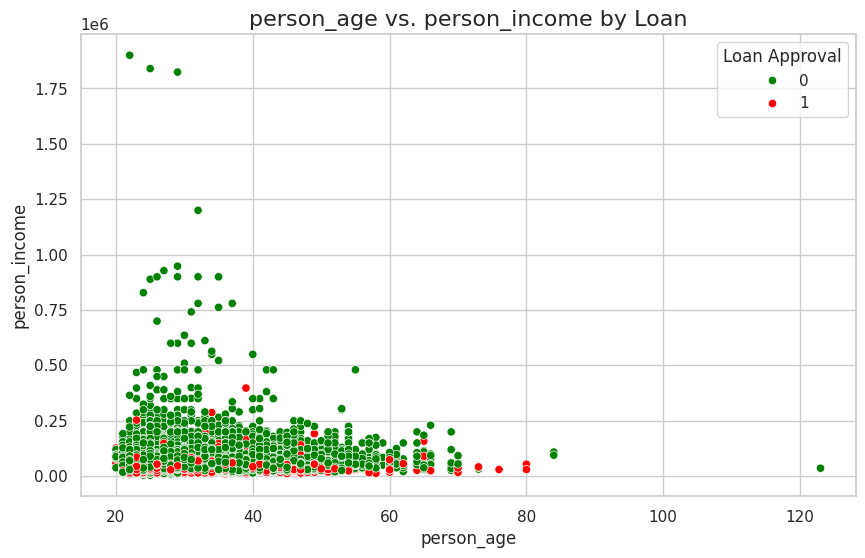

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='person_age', y='person_income', hue='loan_status', palette={0: 'green', 1: 'red'})
plt.title('person_age vs. person_income by Loan', fontsize= 16)
plt.xlabel('person_age')
plt.ylabel('person_income')
plt.legend(title='Loan Approval')
plt.show()
plt.gcf().set_facecolor('lightgrey')
plt.show()

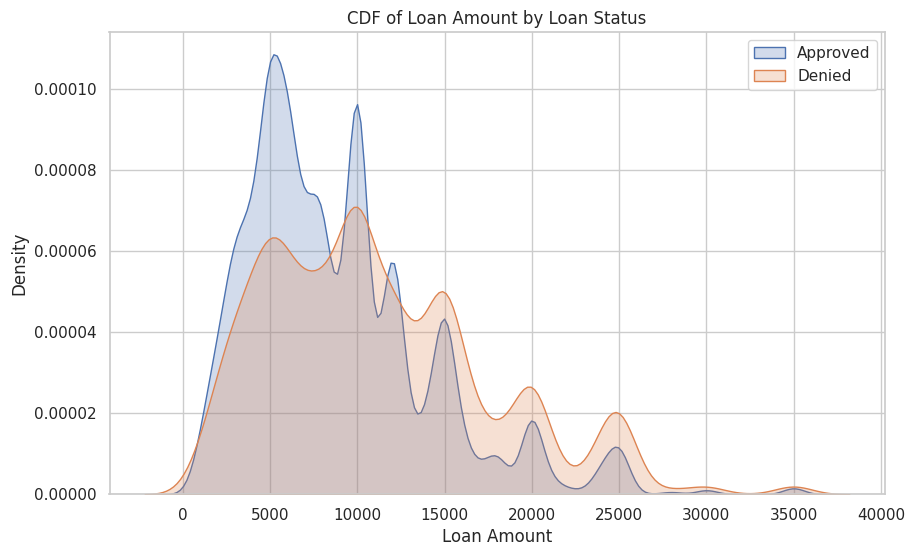

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df_train[df_train['loan_status'] == 0]['loan_amnt'], label='Approved', fill=True)
sns.kdeplot(df_train[df_train['loan_status'] == 1]['loan_amnt'], label='Denied', fill=True)
plt.title('CDF of Loan Amount by Loan Status')
plt.xlabel('Loan Amount')
plt.ylabel('Density')
plt.legend()
plt.show()

## Preprocessing

In [ ]:
def preprocess_data(df_train, df_test):
    label_enc = LabelEncoder()
    label_cols = ['person_home_ownership', 'loan_grade', 'cb_person_default_on_file']
    for col in label_cols:
        df_train[col] = label_enc.fit_transform(df_train[col])
        df_test[col] = label_enc.transform(df_test[col])
    df_train = pd.get_dummies(df_train, columns=['loan_intent'], drop_first=True)
    df_test = pd.get_dummies(df_test, columns=['loan_intent'], drop_first=True)
    target_col = 'loan_status'
    train_columns = df_train.drop(columns=[target_col]).columns
    df_test = df_test.reindex(columns=train_columns, fill_value=0)
    return df_train, df_test

df_train_processed, df_test_processed = preprocess_data(df_train, df_test)

In [ ]:
df_train = df_train_processed
df_test = df_test_processed

df_train.shape, df_test.shape

((58645, 16), (39098, 15))

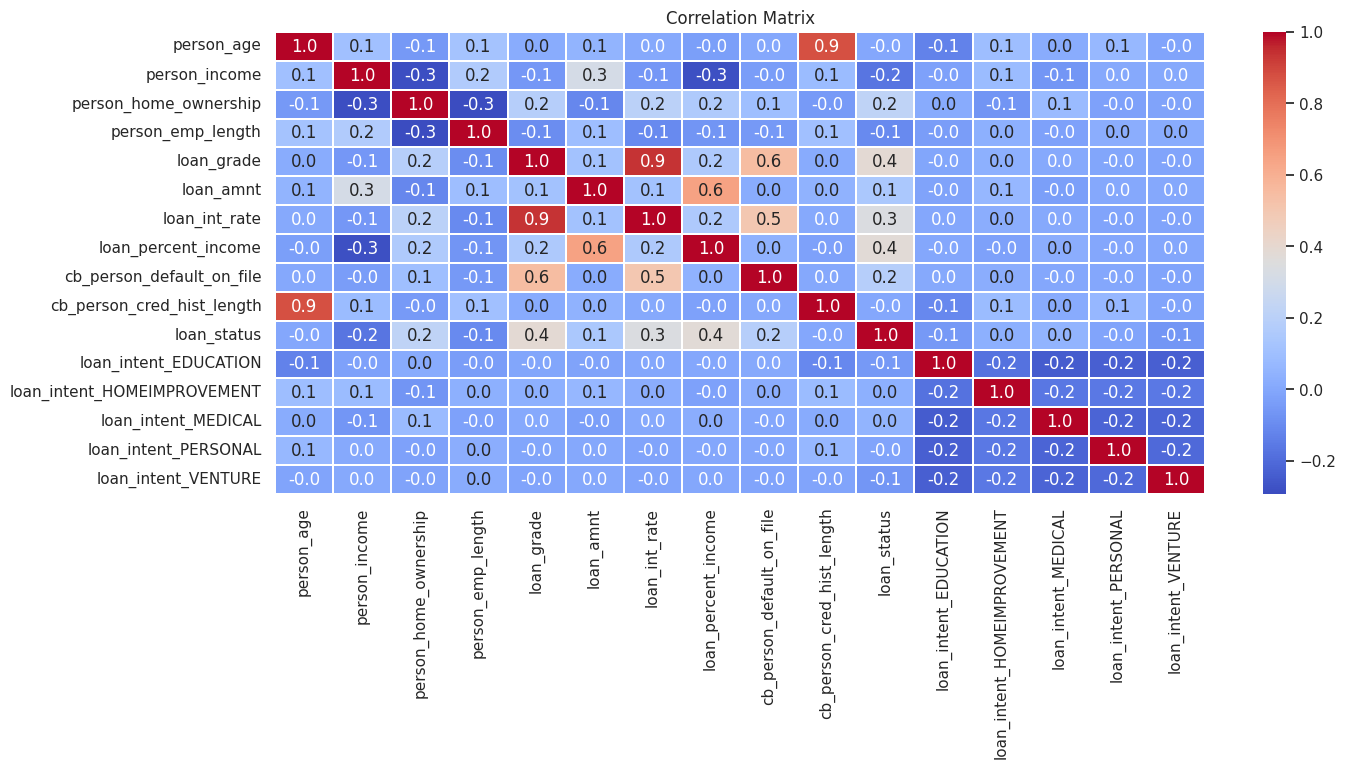

In [ ]:
correlation_matrix = df_train.corr()
plt.figure(figsize=(15, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.2)
plt.title('Correlation Matrix')
plt.show()

In [ ]:
y = df_train['loan_status']
df_train = df_train.drop(['loan_status'],axis=1)
X = df_train

In [ ]:
scaler = StandardScaler()
scaled_train_data = df_train
scaled_test_data = df_test

## Model Training

In [ ]:
lgb_params = {
    'objective': 'binary',
        'n_estimators': 3000,
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'random_state': 42,
        'learning_rate':0.0322942967545754,
        'num_leaves': 24,
        'max_depth': 15,
        'min_data_in_leaf': 25,
        'feature_fraction': 0.6236144085285287,
        'bagging_fraction': 0.9596685778433888,
        'bagging_freq': 3,
        'verbose' : -1
}

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

lgbm_predictions = np.zeros(len(scaled_train_data))
lgbm_true_labels = np.zeros(len(scaled_train_data))
lgbm_test_predictions = np.zeros(len(scaled_test_data))

for fold, (train_idx, val_idx) in enumerate(kf.split(scaled_train_data, y)):
    X_train, X_val = scaled_train_data.iloc[train_idx], scaled_train_data.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    lgbm_model = LGBMClassifier(**lgb_params)
    lgbm_model.fit(X_train, y_train,
                   eval_set=[(X_val, y_val)],
                   eval_metric='auc')

    lgbm_fold_preds = lgbm_model.predict_proba(X_val)[:, 1]
    lgbm_fold_test_preds = lgbm_model.predict_proba(scaled_test_data)[:, 1]
    lgbm_predictions[val_idx] = lgbm_fold_preds
    lgbm_true_labels[val_idx] = y_val
    lgbm_test_predictions += lgbm_fold_test_preds / n_splits

overall_metric_lgbm = roc_auc_score(lgbm_true_labels, lgbm_predictions)
print("Overall AUC (LGBMClassifier):", overall_metric_lgbm)

Overall AUC (LGBMClassifier): 0.9562025439130687


## Model Examination

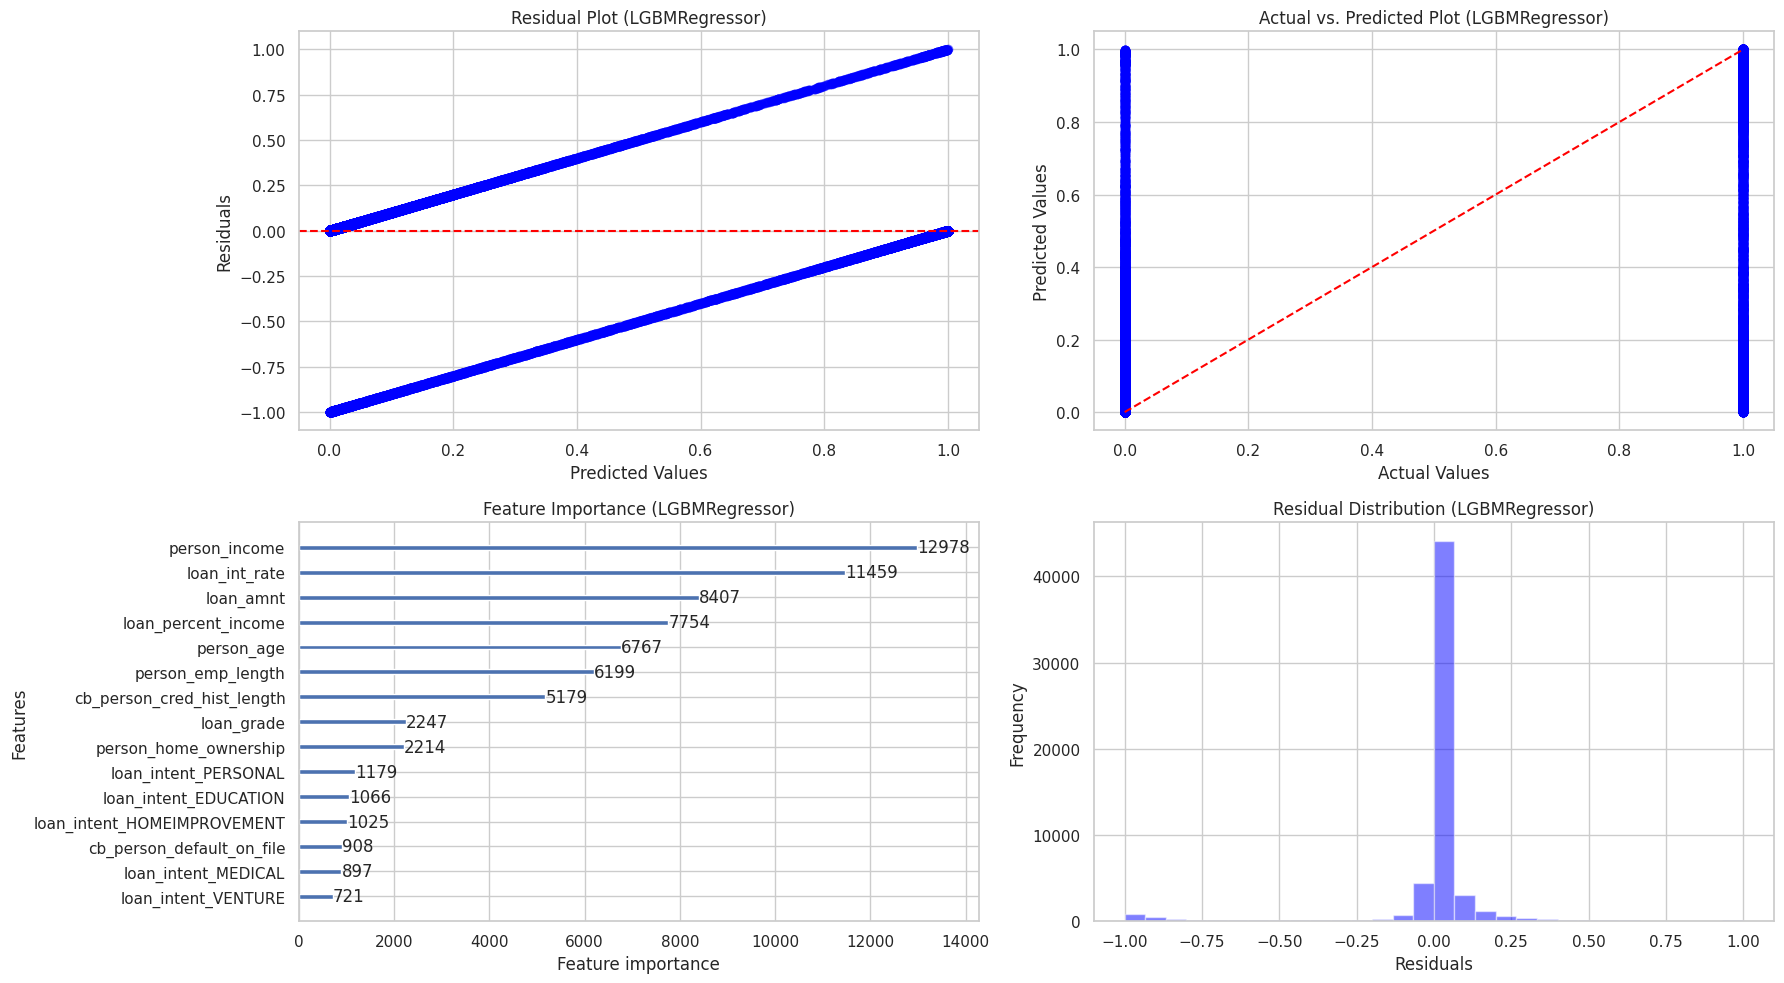

In [ ]:
from lightgbm import plot_importance

lgbm_residuals = lgbm_predictions - lgbm_true_labels
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 10))

axes[0, 0].scatter(lgbm_predictions, lgbm_residuals, color='blue', alpha=0.5)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_title('Residual Plot (LGBMRegressor)')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].grid(True)


axes[0, 1].scatter(lgbm_true_labels, lgbm_predictions, color='blue', alpha=0.5)
axes[0, 1].plot([min(lgbm_true_labels), max(lgbm_true_labels)], [min(lgbm_true_labels), max(lgbm_true_labels)], color='red', linestyle='--')
axes[0, 1].set_title('Actual vs. Predicted Plot (LGBMRegressor)')
axes[0, 1].set_xlabel('Actual Values')
axes[0, 1].set_ylabel('Predicted Values')
axes[0, 1].grid(True)

plot_importance(lgbm_model, ax=axes[1, 0], figsize=(10, 6))
axes[1, 0].set_title('Feature Importance (LGBMRegressor)')

axes[1, 1].hist(lgbm_residuals, bins=30, color='blue', alpha=0.5)
axes[1, 1].set_title('Residual Distribution (LGBMRegressor)')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True)
plt.tight_layout()
plt.show()

## Submitting results

In [ ]:
df_sub = pd.read_csv('/content/drive/MyDrive/Code/Kaggle Projects/Loan Aproval Predictions/sample_submission.csv')
df_sub.head()

,id,loan_status
0,58645,0.5
1,58646,0.5
2,58647,0.5
3,58648,0.5
4,58649,0.5


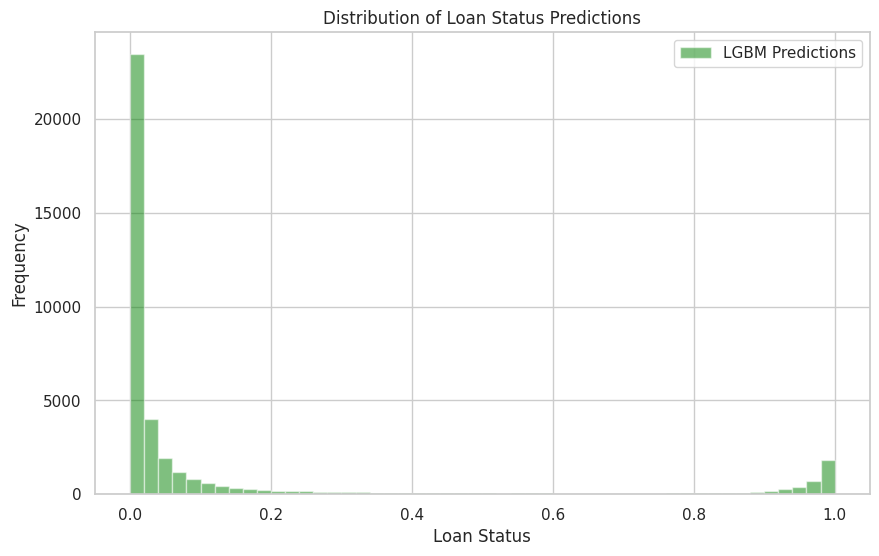

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(lgbm_test_predictions, bins=50, alpha=0.5, color='green', label='LGBM Predictions')
plt.xlabel('Loan Status')
plt.ylabel('Frequency')
plt.title('Distribution of Loan Status Predictions')
plt.legend()
plt.show()

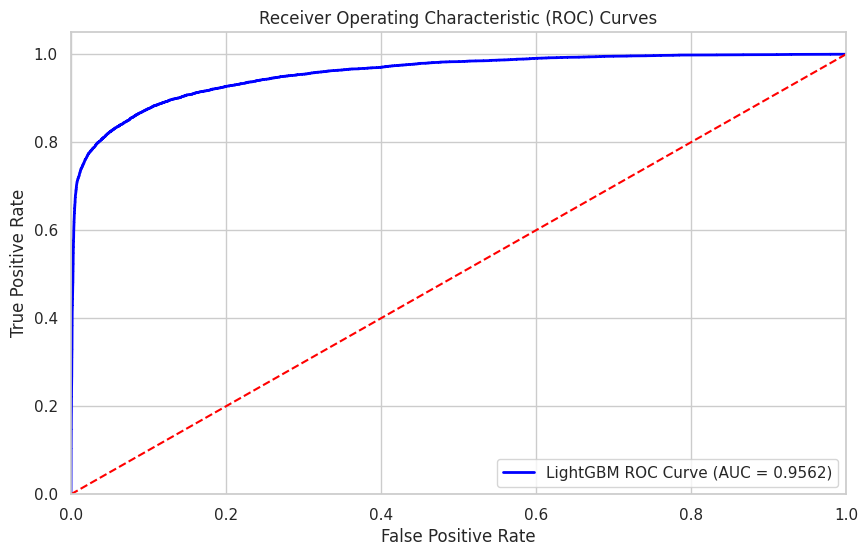

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr_lgbm, tpr_lgbm, _ = roc_curve(lgbm_true_labels, lgbm_predictions)
roc_auc_lgbm = auc(fpr_lgbm, tpr_lgbm)

plt.figure(figsize=(10, 6))
plt.plot(fpr_lgbm, tpr_lgbm, color='blue', lw=2, label=f'LightGBM ROC Curve (AUC = {roc_auc_lgbm:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [ ]:
df_sub['loan_status'] = lgbm_test_predictions
df_sub.head()

,id,loan_status
0,58645,0.999006
1,58646,0.006040
2,58647,0.832397
3,58648,0.006411
4,58649,0.044484


In [ ]:
df_sub.to_csv('submission.csv', index=False)